# Example notebook for CIFAR image classification training

In this example notebook, we'll guide you through the processing of training a CNN with Adam and FishLeg optimizers and getting results

## Step 0: Import necessary packages

In [1]:
!pip install -q -r requirements.txt 
!pip install -q pandas

In [2]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm


import time
import os
import sys
import matplotlib.pyplot as plt
import torch.optim as optim
from datetime import datetime
from utils import class_accuracy
from torch.utils.tensorboard import SummaryWriter

from data_utils import read_data_sets

torch.set_default_dtype(torch.float32)

sys.path.append("../src")

from optim.FishLeg import FishLeg, FISH_LIKELIHOODS, initialise_FishModel


from torchsummary import summary

import copy

import pandas as pd


/home/xzcapwsl/.conda/envs/fishlegnotebook/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_212138/3088275675.py:29: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Step 1: Set up the environment for training the CNN

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

seed = 13
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step 2: Construct the function for training model

In [4]:
train_df_per_step = pd.DataFrame(columns=['loss', 'acc', 'time_taken'])

In [5]:
df_temp = pd.DataFrame([[1, 2, 10]], columns=['loss', 'acc', 'time_taken'])
train_df_per_step = pd.concat([train_df_per_step, df_temp], ignore_index=True)
train_df_per_step = pd.concat([train_df_per_step, df_temp], ignore_index=True)

In [6]:
train_df_per_step

,loss,acc,time_taken
0,1,2,10
1,1,2,10


In [7]:
def train_model(model, train_loader, test_loader, opt, likelihood, class_accuracy, epochs=2, device='cuda'):
    train_df_per_step = pd.DataFrame(columns=['loss', 'acc', 'step_time'])
    test_df_per_step = pd.DataFrame(columns=['loss', 'acc'])
    df_per_epoch = pd.DataFrame(columns=['train_loss', 'train_acc', 'epoch_time', 'test_loss', 'test_acc'])
    st = time.time()
    eval_time = 0

    for epoch in range(1, epochs + 1):
        with tqdm(train_loader, unit="batch") as tepoch:
            running_loss = 0
            running_acc = 0
            for n, (batch_data, batch_labels) in enumerate(tepoch, start=1):
                tepoch.set_description(f"Epoch {epoch}")

                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

                opt.zero_grad()
                output = model(batch_data)

                loss = likelihood(output, batch_labels)

                running_loss += loss.item()
                running_acc += class_accuracy(output, batch_labels).item()

                loss.backward()
                opt.step()

                et = time.time()     

                df_temp = pd.DataFrame([[loss.item(), class_accuracy(output, batch_labels).item(), et-st]], columns=['loss', 'acc', 'step_time'])
                if train_df_per_step.empty:
                    train_df_per_step = df_temp
                else:
                    train_df_per_step = pd.concat([train_df_per_step, df_temp], ignore_index=True)

                if n % 50 == 0:
                    model.eval()

                    running_test_loss = 0
                    running_test_acc = 0

                    for m, (test_batch_data, test_batch_labels) in enumerate(test_loader, start=1):
                        test_batch_data, test_batch_labels = test_batch_data.to(device), test_batch_labels.to(device)

                        test_output = model(test_batch_data)

                        test_loss = likelihood(test_output, test_batch_labels)

                        running_test_loss += test_loss.item()
                        running_test_acc += class_accuracy(test_output, test_batch_labels).item()

                        df_temp = pd.DataFrame([[test_loss.item(), class_accuracy(test_output, test_batch_labels).item()]], columns=['loss', 'acc'])
                        if test_df_per_step.empty:
                            test_df_per_step = df_temp
                        else:
                            test_df_per_step = pd.concat([test_df_per_step, df_temp], ignore_index=True)

                    running_test_loss /= m
                    running_test_acc /= m

                    tepoch.set_postfix(acc=100 * running_acc / n, test_acc=running_test_acc * 100)
                    model.train()
                    eval_time += time.time() - et
            
            epoch_time = time.time() - st - eval_time
            tepoch.set_postfix(loss=running_loss / n, test_loss=running_test_loss, epoch_time=epoch_time)


            df_temp = pd.DataFrame([[running_loss / n, 100 * running_acc / n, epoch_time, running_test_loss, 100 * running_test_acc]], columns=['train_loss', 'train_acc', 'epoch_time', 'test_loss', 'test_acc'])

            if df_per_epoch.empty:
                df_per_epoch = df_temp
            else:
                df_per_epoch = pd.concat([df_per_epoch, df_temp], ignore_index=True)

    return model, train_df_per_step, test_df_per_step, df_per_epoch


## Step 3: Reading in CIFAR data

In [8]:
dataset = read_data_sets("MNIST", "../data/", if_autoencoder=False, reshape=False)

Begin loading data for MNIST
Data read from ../data/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/data/MNIST_data/t10k-images-idx3-ubyte.gz
Data read from ../data/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/data/MNIST_data/t10k-labels-idx1-ubyte.gz
Succesfully loaded MNIST dataset.


In [9]:
## Dataset
train_dataset = dataset.train
test_dataset = dataset.test

print("Train size: ", train_dataset.num_examples)
print("Test size: ", test_dataset.num_examples)
print("Image shape: ", train_dataset.images.shape[1:])

Train size:  60000
Test size:  10000
Image shape:  (1, 28, 28)


In [10]:
def plot_images(dataset, n_images):
    fig, ax = plt.subplots(1, n_images, figsize=(n_images, 1))
    for i in range(n_images):
        ax[i].imshow(dataset.images[i].reshape(28, 28), cmap="gray")
        ax[i].axis("off")
        label_one_hot = train_dataset.labels[i]
        label = np.argmax(label_one_hot)
        ax[i].set_title(f"Label: {label}")
    plt.show()

### Plot image for classification

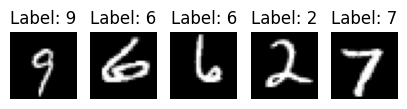

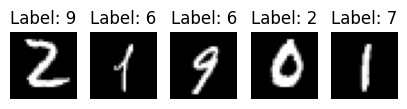

In [11]:
plot_images(train_dataset, 5)
plot_images(test_dataset, 5)

In [12]:
batch_size = 500


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

aux_loader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

## Step 4: Initialise the model

The following code constructs a vanilla CNN model

In [13]:
model = nn.Sequential(
    nn.Conv2d(
        in_channels=1,
        out_channels=16,
        kernel_size=5,
        stride=1,
        padding=2,
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(16 * 14 * 14, 10),
)

adam_model = copy.deepcopy(model)


scale_factor = 1
damping = 0.1
fishleg_model = initialise_FishModel(
    copy.deepcopy(model), module_names="__ALL__", fish_scale=scale_factor / damping
)

### Adam CNN summary

In [14]:
summary(adam_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
           Flatten-4                 [-1, 3136]               0
            Linear-5                   [-1, 10]          31,370
Total params: 31,786
Trainable params: 31,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.12
Estimated Total Size (MB): 0.36
----------------------------------------------------------------


### FishLeg CNN summary

In [15]:
summary(fishleg_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        FishConv2d-1           [-1, 16, 28, 28]             416
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
           Flatten-4                 [-1, 3136]               0
        FishLinear-5                   [-1, 10]          31,370
Total params: 31,786
Trainable params: 31,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.12
Estimated Total Size (MB): 0.36
----------------------------------------------------------------


## Step 5: Training with Adam

The work flow:

- We specify a custom implementation of softmax likelihood which defines the way to compute loss in our classification tasks.
- We then specify the hyperparameters: Learning rate, weight decay and optimizers.
- Lastly, we train the model with these hyperparameters and the data specified above.


Hyperparameters:

- Learning rate: Controls the step size in updating weights during training.
- Weight decay: Adds a penalty on large weights to reduce overfitting and improve model generalization.
- Optimizer: An algorithm that adjusts weights adaptively for each parameter to minimize the loss function more efficiently.

In [16]:
likelihood = FISH_LIKELIHOODS["softmax"](device=device)

lr = 0.0005
# betas = (0.7, 0.9)
weight_decay = 1e-5
# eps = 1e-8
epoch = 10

opt = optim.Adam(
    adam_model.parameters(),
    lr=lr,
    # betas=betas,
    weight_decay=weight_decay,
    # eps=eps,
)


adam_trained_model, adam_train_df_per_step, adam_test_df_per_step, adam_df_per_epoch = train_model(adam_model, train_loader, test_loader, opt, likelihood, class_accuracy, epochs=epoch, device=device)


  0%|          | 0/120 [00:00<?, ?batch/s]/home/xzcapwsl/GroupProject/FishLeg/examples/data_utils.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self._images[idx]), torch.tensor(self._labels[idx])
Epoch 10: 100%|██████████| 120/120 [00:03<00:00, 30.26batch/s, acc=97.7, test_acc=97.8]


## Step 6: Training with FishLeg

The workflow:

- We specify all the hyperparameters(learning rate, weight_decay,etc).
- We initialise a model with replacement of certain layers with corresponding 'FishLeg' layers
- We specify the FishLeg optimizer
- Lastly, we train the model


Hyperparameters:

- Learning rate: Controls the step size in updating weights during training.
- Weight decay: Adds a penalty on large weights to reduce overfitting and improve model generalization.
- Optimizer: An algorithm that adjusts weights adaptively for each parameter to minimize the loss function more efficiently.
- beta: coefficient for running averages of gradient (default: 0.9)
- aux_lr: learning rate for the auxiliary parameters, using Adam (default: 1e-3)
- aux_eps: Term added to the denominator to improve numerical stability for auxiliary parameters (default: 1e-8)
- damping: Static damping applied to Fisher matrix, :math:\gamma,for stability when FIM becomes near-singular. (default: 5e-1)

In [17]:
lr = 0.02
beta = 0.9
weight_decay = 1e-5

aux_lr = 1e-4
aux_eps = 1e-8
scale_factor = 1
damping = 0.1
update_aux_every = 3

initialization = "normal"
normalization = True

epoch = 10

In [18]:
opt = FishLeg(
    fishleg_model,
    aux_loader,
    likelihood,
    lr=lr,
    beta=beta,
    weight_decay=weight_decay,
    aux_lr=aux_lr,
    aux_betas=(0.9, 0.999),
    aux_eps=aux_eps,
    damping=damping,
    update_aux_every=update_aux_every,
    # writer=writer,
    method="antithetic",
    method_kwargs={"eps": 1e-4},
    precondition_aux=True,
)
fishleg_trained_model, fishleg_train_df_per_step, fishleg_test_df_per_step, fishleg_df_per_epoch = train_model(fishleg_model, train_loader, test_loader, opt, likelihood, class_accuracy, epochs=epoch, device=device)

  0%|          | 0/120 [00:00<?, ?batch/s]/home/xzcapwsl/GroupProject/FishLeg/examples/data_utils.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self._images[idx]), torch.tensor(self._labels[idx])
Epoch 1:   0%|          | 0/120 [00:00<?, ?batch/s]

Epoch 10: 100%|██████████| 120/120 [00:09<00:00, 12.35batch/s, acc=98.1, test_acc=98.1]


## Plot for comparison between Adam and FishLeg

Text(0, 0.5, 'Training Loss')

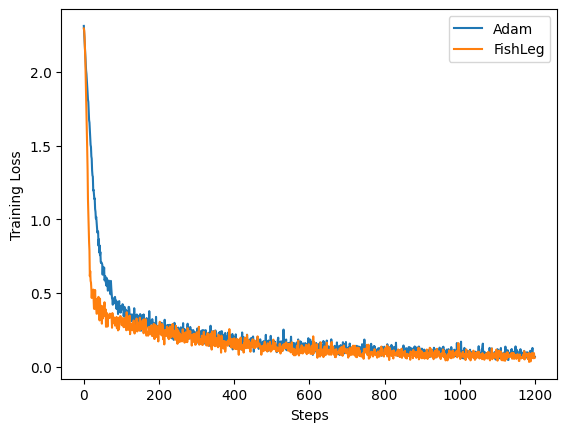

In [19]:
plt.plot(adam_train_df_per_step['loss'], label="Adam")
plt.plot(fishleg_train_df_per_step['loss'], label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Steps")
plt.ylabel("Training Loss")

Text(0, 0.5, 'Training Accuracy')

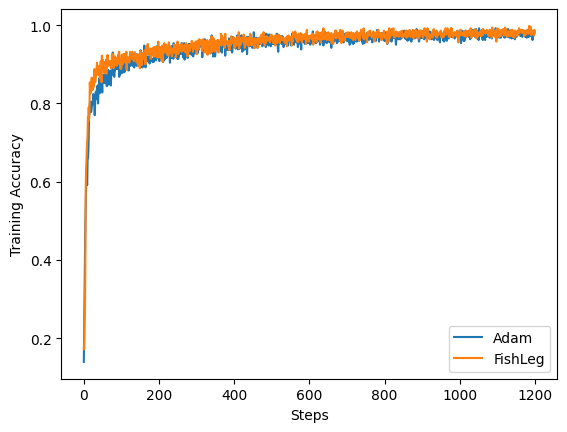

In [20]:
plt.plot(adam_train_df_per_step['acc'], label="Adam")
plt.plot(fishleg_train_df_per_step['acc'], label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Steps")
plt.ylabel("Training Accuracy")

Text(0, 0.5, 'Training Loss')

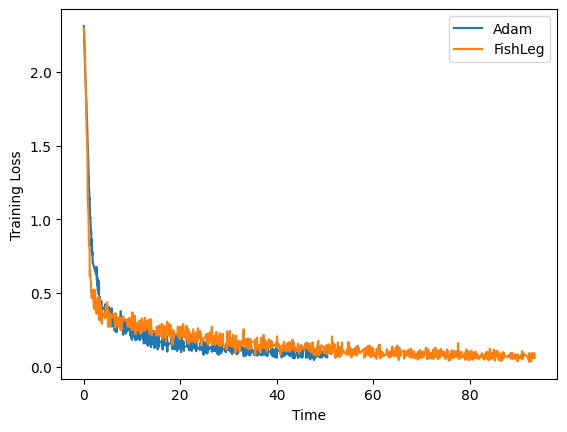

In [21]:
plt.plot(adam_train_df_per_step['step_time'], adam_train_df_per_step['loss'], label="Adam")
plt.plot(fishleg_train_df_per_step['step_time'], fishleg_train_df_per_step['loss'], label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Time")
plt.ylabel("Training Loss")

Text(0, 0.5, 'Training Accuracy')

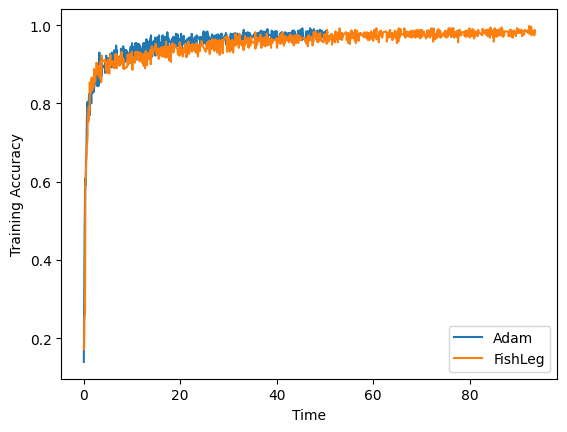

In [22]:
plt.plot(adam_train_df_per_step['step_time'], adam_train_df_per_step['acc'], label="Adam")
plt.plot(fishleg_train_df_per_step['step_time'], fishleg_train_df_per_step['acc'], label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Time")
plt.ylabel("Training Accuracy")

Text(0, 0.5, 'Loss')

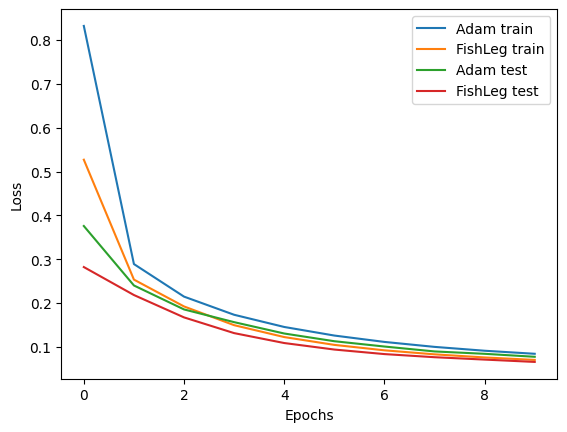

In [23]:
plt.plot(adam_df_per_epoch['train_loss'], label="Adam train")
plt.plot(fishleg_df_per_epoch['train_loss'], label="FishLeg train")
plt.plot(adam_df_per_epoch['test_loss'], label="Adam test")
plt.plot(fishleg_df_per_epoch['test_loss'], label="FishLeg test")
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

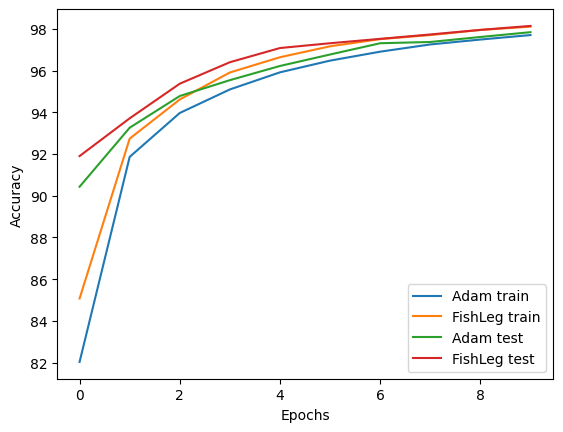

In [24]:
plt.plot(adam_df_per_epoch['train_acc'], label="Adam train")
plt.plot(fishleg_df_per_epoch['train_acc'], label="FishLeg train")
plt.plot(adam_df_per_epoch['test_acc'], label="Adam test")
plt.plot(fishleg_df_per_epoch['test_acc'], label="FishLeg test")
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [26]:
adam_df_per_epoch

,train_loss,train_acc,epoch_time,test_loss,test_acc
0,0.832100,82.031667,4.174254,0.375844,90.429999
1,0.289061,91.861667,7.906380,0.240240,93.260001
2,0.214815,93.966666,11.242151,0.185599,94.780000
3,0.173420,95.095000,14.648101,0.156586,95.540000
4,0.145616,95.915000,19.036226,0.130697,96.220000
5,0.126050,96.476666,23.467304,0.113113,96.770000
6,0.111509,96.905000,28.320931,0.101000,97.310000
7,0.100199,97.251667,32.436491,0.089817,97.370000
8,0.091407,97.486667,36.406111,0.084405,97.610000
9,0.084461,97.701667,39.384799,0.077621,97.839999


Text(0, 0.5, 'Training loss')

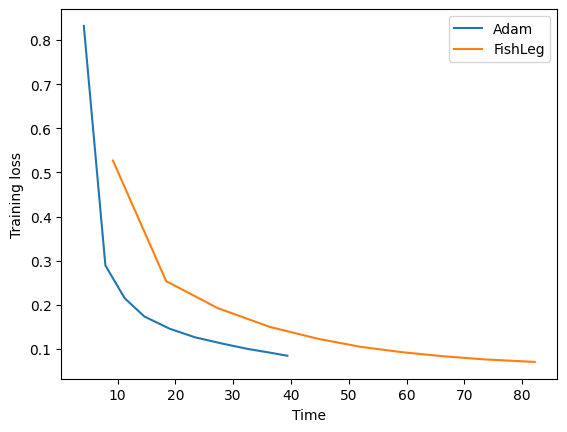

In [28]:
plt.plot(adam_df_per_epoch['epoch_time'], adam_df_per_epoch['train_loss'], label="Adam")
plt.plot(fishleg_df_per_epoch['epoch_time'], fishleg_df_per_epoch['train_loss'], label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Time")
plt.ylabel("Training loss")

Text(0, 0.5, 'Training accuracy')

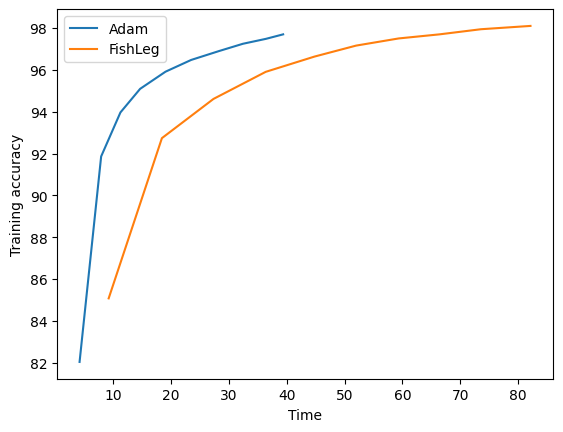

In [29]:
plt.plot(adam_df_per_epoch['epoch_time'], adam_df_per_epoch['train_acc'], label="Adam")
plt.plot(fishleg_df_per_epoch['epoch_time'], fishleg_df_per_epoch['train_acc'], label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Time")
plt.ylabel("Training accuracy")